Ce notebook est consacré à l'exploration, l'analyse et la préparation des données en vue des étapes de modélisations à suivre.

# **Configuration de l'environnement**

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import emoji
import time
from tqdm import tqdm
from typing import List
import itertools
from collections import Counter
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils import show_nums_axes
import mlflow
import mlflow.spacy

In [2]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize tdqm pandas
tqdm.pandas()

# **Lecture des données**

J'utilise le dataset open source `sentiment140` qui contient 1,6 millions de tweets annotés en 0 (négatif) ou 4 (positif).<br>
Le dataset est disponible sur Kaggle à l'adresse suivante : https://www.kaggle.com/kazanova/sentiment140


Je décide de lire tout le fichier à l'exception de la colonne `flag` qui contient la valeur unique **NO_QUERY**.

In [3]:
# Path to the csv file
path = "../data/raw/training.1600000.processed.noemoticon.csv"

# Read the file
df = pd.read_csv(
    path,
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"],
    usecols=["target", "ids", "date", "user", "text"],  # remove flag column
    parse_dates=["date"],
    encoding="utf-8",
    encoding_errors="replace",  # replace the errors with unicode symbol � (U+FFFD)
).sort_values(by="date", ascending=True)  # sort by date

# Display the info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 799999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB
None


On constate qu'il n'y a pas de valeurs nulles dans ce dataset.<br>

Voici un aperçu des données :

In [4]:
display(df.head(20))

,target,ids,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,2009-04-06 22:20:03,mybirch,Need a hug
7,0,1467811594,2009-04-06 22:20:03,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,2009-04-06 22:20:05,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,2009-04-06 22:20:09,mimismo,@twittera que me muera ?


# **Analyse pré-exploratoire et préparation des données**

Après avoir prévisualisé les données, je vais transformer les données afin de pouvoir les étudier plus facilement.

Les colonnes `ids` et `user` vont être encodées à l'aide d'un label encoder.<br>
Les modalités de la variable `target` sont ramenées à 1, pour les tweets positifs, et 0 pour les tweets négatifs.<br>
Enfin, la variable `date`est transformée en 3 champs : `month`, `day` et `hour`.

In [5]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the desired columns
for col in ["ids", "user"]:
    df[col] = encoder.fit_transform(df[col])

# Replace 4 with 1 in the target column
df["target"] = df["target"].replace(4, 1)

# Finally, create new columns for month, day, and hour and drop date
df = df.assign(
    **{
        "month": lambda x: x.date.progress_apply(lambda x: x.month),
        "day": lambda x: x.date.progress_apply(lambda x: x.day),
        "hour": lambda x: x.date.progress_apply(lambda x: x.hour),
    }
).drop(columns=["date"])

100%|██████████| 1600000/1600000 [00:02<00:00, 787472.51it/s] 


Enfin, je vais optimiser les types de données pour ces nouvelles variables.

In [6]:
# Convert the datatypes to save memory
df = df.astype(
    {
        "target": "int8",
        "ids": "int32",
        "user": "int32",
        "month": "int8",
        "day": "int8",
        "hour": "int8",
    }
)

In [7]:
# Display the data head to check the changes
df.head()

,target,ids,user,text,month,day,hour
0,0,0,242711,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,6,22
1,0,1,577449,is upset that he can't update his Facebook by ...,4,6,22
2,0,2,490699,@Kenichan I dived many times for the ball. Man...,4,6,22
3,0,3,65794,my whole body feels itchy and like its on fire,4,6,22
4,0,4,113308,"@nationwideclass no, it's not behaving at all....",4,6,22


**Vérification des duplicatas**

Je vérifie s'il y a des duplicatas dans le dataset de manière générale.<br>
Regardons plus précisemment si les colonnes ids, target et text contiennent des duplicatas.

In [8]:
print(df.duplicated().sum(), "duplicata trouvé.")
print(
    df.duplicated(subset=["ids", "target", "text"]).sum(),
    "duplicata trouvé sur les colonnes ids, target et text.",
)

0 duplicata trouvé.
0 duplicata trouvé sur les colonnes ids, target et text.


In [9]:
print("Nombre de tweets uniques: ", df["ids"].nunique())
print(
    "Nombre de tweets annotés à la fois positivement et négativement: ",
    df["ids"].size - df["ids"].nunique(),
)

Nombre de tweets uniques:  1598315
Nombre de tweets annotés à la fois positivement et négativement:  1685


Il est intérressant de constater que plusieurs tweets avec le même id ont été annotés différemment.<br>
Cela va introduire de l'incohérence lors de l'entraînement du modèle et affecter sa capacité à généraliser.<br>

Le plus simple est de retirer ces tweets du jeu d'entraînement.<br>
Regardons un exemple de tweet avec des valeurs différentes:

In [10]:
# Display 4 examples of duplicated rows with both positive and negative target
with pd.option_context("display.max_colwidth", 150):
    display(df.loc[df["ids"].duplicated(keep=False), ["text", "target"]].head(4))

,text,target
800261,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,1
213,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,0
800300,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",1
275,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",0


In [11]:
# Drop duplicates ids with both positive and negative target
df = df.drop_duplicates(subset=["ids"], keep=False)
print(
    "Nouvelle taille du jeu de données après suppression des duplicata sur ids: ",
    len(df),
)

Nouvelle taille du jeu de données après suppression des duplicata sur ids:  1596630


J'ai pu constaté qu'il n'y avait pas de valeur nulle dans le dataset donc nous n'effectuerons pas de vérification à ce sujet.<br>
Toutefois, une analyse sémantique des tweets avec de possibles valeurs interprétables comme "nulles" pourrait déceler des valeurs à supprimer.

# **Analyse exploratoire, feature engineering**

Dans un premier temps, vérifions la cohérence des variables numériques avec leurs statistiques descriptives:

In [12]:
# Display the summary statistics of numerical columns
with pd.option_context(
    "display.max_colwidth", 100, "display.float_format", "{:.2f}".format
):
    display(df.describe())

,target,ids,user,month,day,hour
count,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00
mean,0.50,799301.29,330323.25,5.51,14.81,10.96
std,0.50,461450.15,191341.79,0.61,9.79,7.22
min,0.00,0.00,0.00,4.00,1.00,0.00
25%,0.00,399669.25,164668.00,5.00,6.00,5.00
50%,0.50,799342.50,329997.00,6.00,16.00,10.00
75%,1.00,1199004.75,496888.75,6.00,21.00,18.00
max,1.00,1598314.00,659774.00,6.00,31.00,23.00


Rien d'anormal dans les statistiques descriptives des variables numériques.<br>
On constate que la période de temps est limité sur 3 mois.

In [13]:
# Statistics of the number of tweets per user
df["user"].value_counts().describe()

count    659502.000000
mean          2.420963
std           4.697115
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

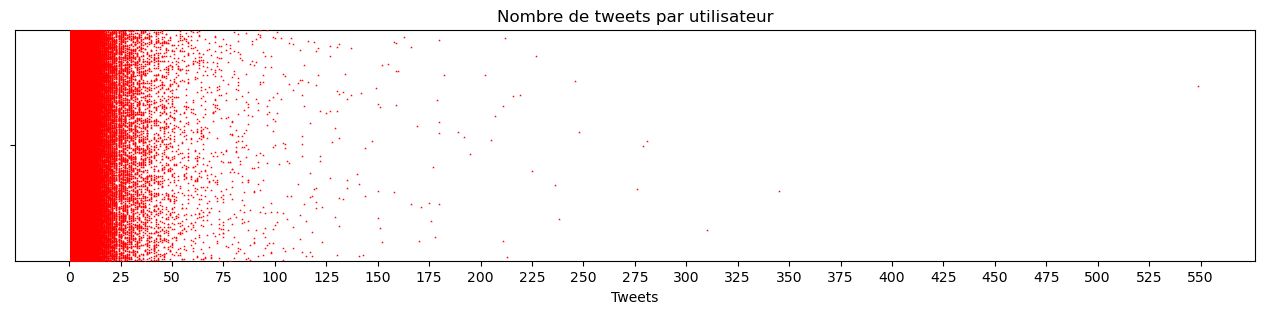

In [14]:
# Show a stripplot of the number of tweets per user
fig, ax = plt.subplots(figsize=(16, 3))
sns.stripplot(
    x=df["user"].value_counts(), jitter=0.5, size=2, marker="*", color="red", ax=ax
)
ax.set(title="Nombre de tweets par utilisateur", xlabel="Tweets")
ax.set_xticks(range(0, 575, 25))
plt.show()

En moyenne sur le jeu de données, on a 2,4 tweets par utilisateur unique.<br>
Certains utilisateurs sont très représentés dans le jeu de données avec un maximum de 549 tweets.

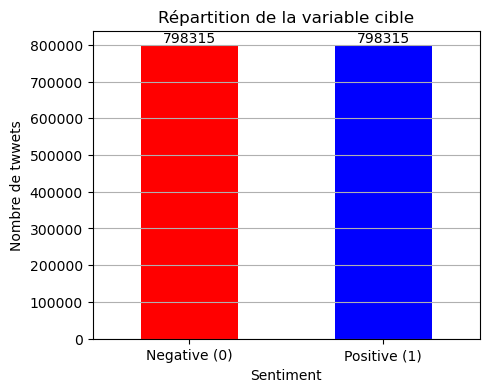

In [15]:
# Display a barplot of the number of tweets depending of the sentiment
fig, ax = plt.subplots(figsize=(5, 4))
df["target"].value_counts().plot(kind="bar", color=["red", "blue"], ax=ax).set(
    title="Répartition de la variable cible",
    xlabel="Sentiment",
    ylabel="Nombre de twwets",
)
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.grid(axis="y")
show_nums_axes(ax, fmt=".6g")
plt.show()

Le jeu de données présente un équilibre parfait entre les tweets positifs et négatifs.<br>
Cela nous assure une base équilibrée sur le jeu d'entraînement et de test.

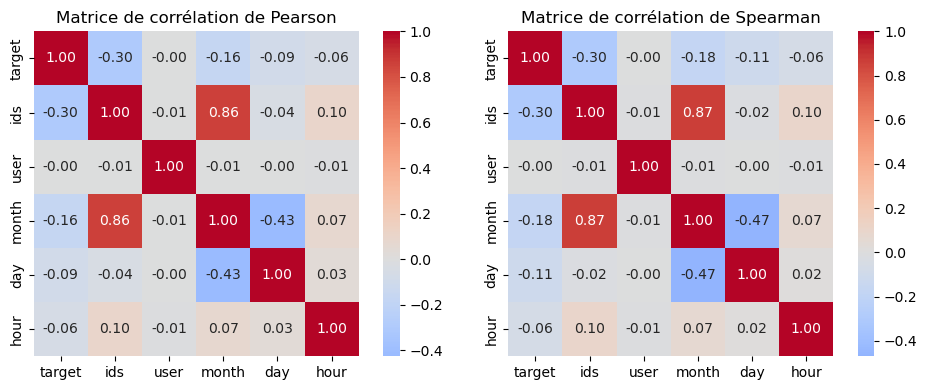

In [16]:
# Draw Pearson and Spearman correlation matrixes
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for axes, method in zip(ax.flatten(), ("pearson", "spearman")):
    sns.heatmap(
        df.select_dtypes(exclude=["object"]).corr(method=method),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        ax=axes,
    )
    axes.set_title(f"Matrice de corrélation de {method.capitalize()}")
plt.show()

Il n'y a pas de relation linéaire et/ou monotone entre les features numériques et la cible.<br>
Essayons de regarder si on peut détecter une relation entre les variables temporelles et la cible :

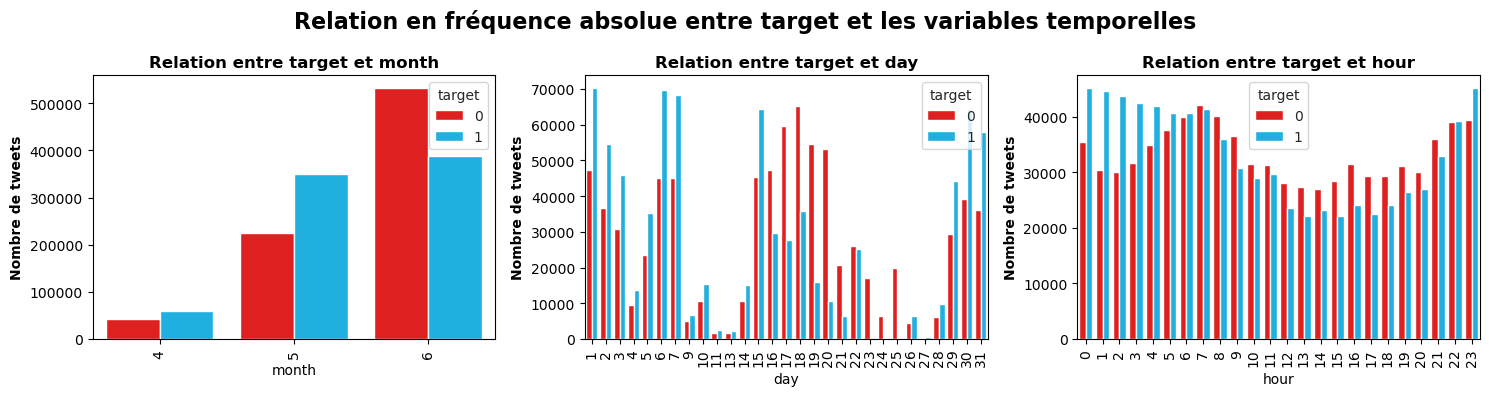

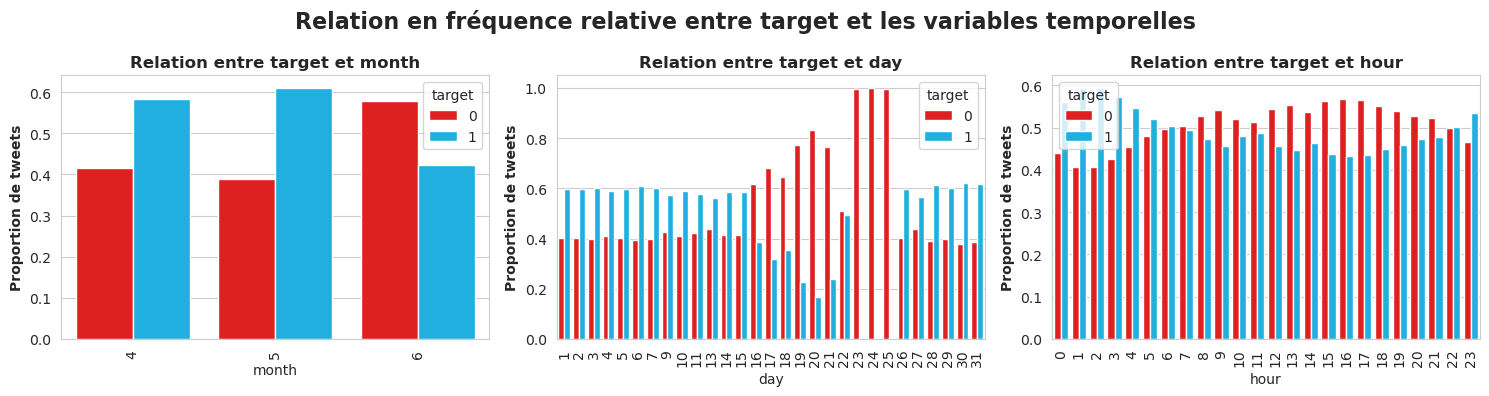

In [17]:
# Display the relation between target and the variables month, day, and hour
for title, method in zip(("absolue", "relative"), ("count", "proportion")):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False, tight_layout=True)
    fig.suptitle(
        f"Relation en fréquence {title} entre target et les variables temporelles",
        fontweight="bold",
        fontsize=16,
    )
    sns.set_style("whitegrid")
    for i, col in enumerate(["month", "day", "hour"]):
        sns.barplot(
            df.groupby(col)["target"]
            .value_counts(normalize=True if title == "relative" else False)
            .reset_index(),
            x=col,
            y=method,
            hue="target",
            palette=["red", "deepskyblue"],
            ax=ax[i],
        )
        ax[i].set_title(f"Relation entre target et {col}", fontweight="bold")
        ax[i].set_xlabel(col)
        ax[i].set_ylabel(
            "Proportion de tweets" if title == "relative" else "Nombre de tweets",
            fontweight="bold",
        )
        ax[i].set_xticks(ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    plt.show()

On peut noter que **certaines journées ne sont pas présentes (le 8 et le 12)**.<br>
Pour une raison inconnue, les jours 23, 24 et 25 sont uniquement **négatifs**.<br>
La répartition des tweets n'est pas uniforme **sur les mois**, avec une concentration beaucoup plus forte en mai (+ de positif) et en juin (+ de négatif) qu'en avril.<br>

On identifie deux relations non linéaires à:
- **l'échelle journalière**: Les tweets négatifs sont plus fréquents en milieu de mois et les tweets positifs en début et fin de mois.
- **l'échelle horaire**: On a deux courbes sinusoidale avec deux cycles différents pour les tweets positifs et négatifs. Celle-ci est vraiment intéressante et pourrait être exploitée pour la création de nouvelles features.

Dans l'absolu, **seule la variable horaire semble avoir un lien avec la target**.<br>
Je vais créer deux nouvelles features basées sur l'heure et les encodées de manière cyclique pour conserver la notion de périodicité et de continuité qui n'est pas capturé par un encodage one-hot ou ordinal.

In [18]:
# Création de deux variables transformées de l'heure avec un encodage cyclique
df = df.assign(
    **{
        "hour_sin": lambda x: np.sin(2 * np.pi * x.hour / 24),
        "hour_cos": lambda x: np.cos(2 * np.pi * x.hour / 24),
    }
)

In [19]:
df[["hour", "hour_sin", "hour_cos"]].describe()

,hour,hour_sin,hour_cos
count,1.596630e+06,1.596630e+06,1.596630e+06
mean,1.096383e+01,8.240894e-02,8.207023e-02
std,7.215811e+00,7.032419e-01,7.013734e-01
min,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.000000e+00,-5.000000e-01,-5.000000e-01
50%,1.000000e+01,2.588190e-01,2.588190e-01
75%,1.800000e+01,7.071068e-01,7.071068e-01
max,2.300000e+01,1.000000e+00,1.000000e+00


A présent, je vais étudier la structure des tweets sur le jeu de données.<br>
Commençons par avoir un aperçu d'une sélection de tweets aléatoires:

In [20]:
with pd.option_context("display.max_colwidth", 150):
    display(df[["text", "target"]].sample(25))

,text,target
930828,@Butterflydiary snaps to you for getting in The Cut! yay Butterfly Diary,1
1250462,"@kylesteed you are welcome, great post, made me think #much_love",1
435847,ugh i feel like crap!,0
602982,"@frak He took the ice cream, and didn't share",0
972454,Thank you Lili! You're a life saver,1
769942,I hate the way this app sometimes posts my mssgs as tweets!,0
1112862,Enjoying a gorgeous Saturday! Yay!,1
659640,@miss_tatyy Im gooood! Aren't you coming down this summer to see everyone? Im so disappointed my trip never worked out,0
472574,back to work,0
191030,Peecee Is made of fail!!,0


Le nom du jeu de données précise que les textes seraient sans emoticons.<br>
Sur ce sample, on constate que les tweets sont relativement courts et uniquement avec pas mal de mentions et quelques hashtags ainsi qu'une url.<br>
De plus, il n'est pas toujours évident de pouvoir classer certains tweets de part leur nature neutre.<br>
Calculons des statistiques pour vérifier ces observations:

In [21]:
# Create a new column for the length of the text
df = df.assign(
    **{
        "text_length": lambda x: x.text.str.len(),
    }
)
# Display the distribution statistics of the text length
print(df.groupby("target")["text_length"].describe())

           count       mean        std  min   25%   50%    75%    max
target                                                               
0       798315.0  74.226052  36.714397  6.0  44.0  69.0  104.0  188.0
1       798315.0  73.764481  36.052728  6.0  44.0  69.0  103.0  359.0


Ces premières statistiques nous confirment qu'il n'y a pas priori pas de tweets "vides" dans le jeu de données.<br>
Le minimum de caractères est de 6 dans ce jeu de données et il est nécessaire fixer un nombre minimum de caractères pour éviter les tweets vides.<br>

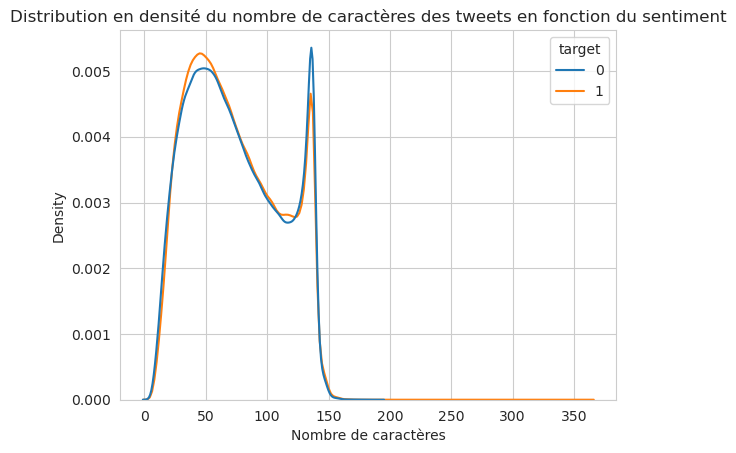

In [22]:
sns.kdeplot(df, x="text_length", color="red", hue="target")
plt.title(
    "Distribution en densité du nombre de caractères des tweets en fonction du sentiment"
)
plt.xlabel("Nombre de caractères")
plt.show()

La courbe de densité comparant les deux classes de sentiment montrent des distributions quasi-identiques.<br>
Les tweets positifs ont davantage de valeur extrêmes ce qui consistue l'unique différence.


Regardons à présent la ponctuation, les hashtags, les urls et les mentions dans les tweets:

In [23]:
# Create & compute the new features
df = df.assign(
    **{
        "punctuation_count": lambda x: x.text.str.count(r"[.!?,;]"),
        "hashtag_count": lambda x: x.text.str.lower().str.count(r"#\w+"),
        "mention_count": lambda x: x.text.str.lower().str.count(r"@\w+"),
        "url_count": lambda x: x.text.str.lower().str.count(
            r"https?://?\S+|www\.\w+\S+"
        ),
    }
)
# Display the summary statistics of the new features
df.filter(
    ["punctuation_count", "hashtag_count", "mention_count", "url_count", "target"]
).groupby("target").agg(["mean", "median", "std", "sum"])

punctuation_count                           hashtag_count         \
                    mean median       std      sum          mean median   
target                                                                    
0               2.401071    2.0  2.623295  1916811      0.022970    0.0   
1               2.479420    2.0  2.704094  1979358      0.032144    0.0   

                        mention_count                          url_count  \
             std    sum          mean median       std     sum      mean   
target                                                                     
0       0.193335  18337      0.394006    0.0  0.536331  314541  0.031014   
1       0.251353  25661      0.589112    1.0  0.620173  470297  0.064604   

                                
       median       std    sum  
target                          
0         0.0  0.176514  24759  
1         0.0  0.252650  51574

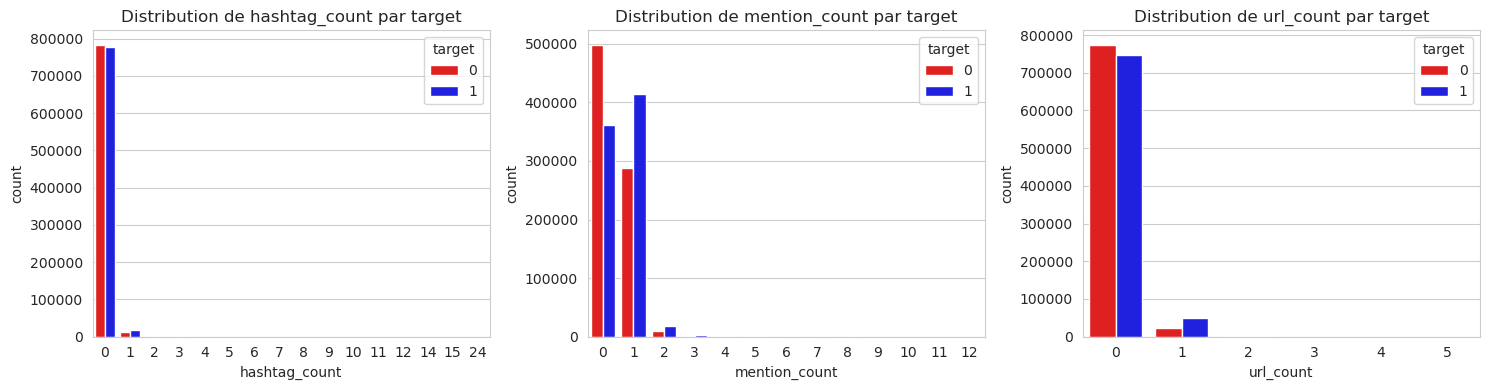

In [24]:
# Représentation de la distribution des nouvelles features discrètes
fig, ax = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for axes, feature in zip(ax.flatten(), ["hashtag_count", "mention_count", "url_count"]):
    sns.countplot(
        df.filter([feature, "target"]),
        x=feature,
        hue="target",
        palette=["red", "blue"],
        ax=axes,
    )
    axes.set_title(f"Distribution de {feature} par target")
plt.show()

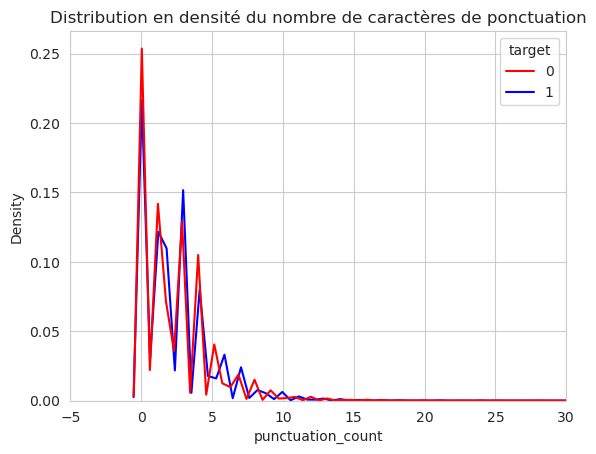

In [25]:
# Display the density distribution of the punctuation count
sns.kdeplot(
    df.filter(["punctuation_count", "target"]),
    x="punctuation_count",
    hue="target",
    palette=["red", "blue"],
).set(
    title="Distribution en densité du nombre de caractères de ponctuation",
    xlim=(-5, 30),
)
plt.show()

Regardons plus en détail les mentions, ce qu'elles contiennnent et l'influence sur la cible:

In [26]:
# Create a new column for the mentions identified in the text
df = df.assign(
    **{
        "first_mention": df["text"].str.lower().str.extract(r"(@\w+)"),
        "mentions": df["text"].str.lower().str.findall(r"(@\w+)"),
    }
)

In [ ]:
# Create a list of all mentions
all_mentions = list(itertools.chain(*df["mentions"].dropna().values))

# Display the most common mentions
counter = Counter(all_mentions)
print("Les 15 mentions les plus fréquentes:")
for mention, count in counter.most_common(15):
    print(f"{mention}: {count}")

Les 15 mentions les plus fréquentes:
@mileycyrus: 4544
@tommcfly: 3876
@ddlovato: 3464
@jonasbrothers: 2376
@davidarchie: 1378
@donniewahlberg: 1330
@jonathanrknight: 1260
@jordanknight: 1150
@mitchelmusso: 1097
@taylorswift13: 1026
@selenagomez: 805
@dougiemcfly: 792
@dannymcfly: 699
@peterfacinelli: 642
@aplusk: 625


In [28]:
len(counter)

343459

Regardons parmi les `first_mention`, leurs statistiques descriptives si certaines ont plus d'impact que d'autres mentions:

In [29]:
mention_df = (
    df.dropna(subset=["first_mention"])
    .groupby("target")["first_mention"]
    .value_counts()
)

print(mention_df.nlargest(10))

target  first_mention   
1       @mileycyrus         2950
        @tommcfly           2143
        @ddlovato           2004
0       @tommcfly           1611
1       @jonasbrothers      1547
0       @mileycyrus         1390
        @ddlovato           1251
1       @davidarchie         949
        @jonathanrknight     765
        @jordanknight        694
Name: count, dtype: int64


A première vue, on peut voir que certaines mentions ont davantage de tweets d'une classe ou d'une autre notamment parmi certaines celébrités populaires.<br>
Je vais calculer le nombre de mentions positives et négatives par mention unique.

In [30]:
# Compute the count of positive mentions
pos_mentions = (
    mention_df.reset_index()
    .loc[mention_df.reset_index()["target"] == 1, :]
    .set_index("first_mention")
)
# Compute the count of negative mentions
neg_mentions = (
    mention_df.reset_index()
    .loc[mention_df.reset_index()["target"] == 0, :]
    .set_index("first_mention")
).reindex(pos_mentions.index, fill_value=0)
# Check that the shapes and index are the same
assert neg_mentions.shape == pos_mentions.shape
assert neg_mentions.index.equals(pos_mentions.index)

Regardons ceux qui dominent le classement des mentions positives et négatives:

In [31]:
pos_mentions.head(5)

,target,count
first_mention,,
@mileycyrus,1,2950
@tommcfly,1,2143
@ddlovato,1,2004
@jonasbrothers,1,1547
@davidarchie,1,949


In [32]:
neg_mentions.head(5)

,target,count
first_mention,,
@mileycyrus,0,1390
@tommcfly,0,1611
@ddlovato,0,1251
@jonasbrothers,0,686
@davidarchie,0,368


In [33]:
# Create a dataframe computing the difference between positive and negative count for each unique mention divide by the sum of both count and multiply by 100
mention_ranking = (
    (
        pos_mentions["count"]
        .subtract(neg_mentions["count"])
        .div(pos_mentions["count"].add(neg_mentions["count"]))
        .mul(100)
    )
    .rename("diff_sentiment_pct")
    .to_frame()
    .merge(
        pos_mentions["count"]
        .add(neg_mentions["count"])
        .rename("tweet_counts")
        .to_frame(),
        left_index=True,
        right_index=True,
    )
)

Regardons à présent les statistiques descriptives de ce classement:

In [34]:
print(mention_ranking.describe())

       diff_sentiment_pct   tweet_counts
count       218101.000000  218101.000000
mean            73.952154       2.755146
std             45.070013      17.842885
min            -93.442623       1.000000
25%             50.000000       1.000000
50%            100.000000       1.000000
75%            100.000000       2.000000
max            100.000000    4340.000000


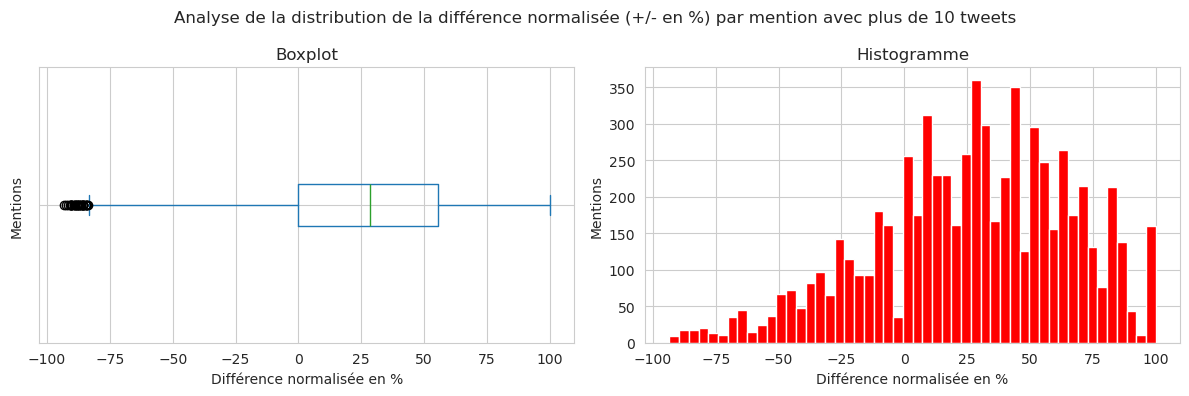

In [35]:
# Create a boxplot and histogram of the difference sentiment percentage
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
fig.suptitle(
    "Analyse de la distribution de la différence normalisée (+/- en %) par mention avec plus de 10 tweets",
)
# Filter mentions with more than 10 tweets and plot the boxplot and histogram
mention_ranking.loc[mention_ranking["tweet_counts"] > 10, "diff_sentiment_pct"].plot(
    kind="box", vert=False, ax=ax[0]
).set(
    title="Boxplot",
    xlabel="Différence normalisée en %",
    ylabel="Mentions",
)
ax[0].set_yticklabels([])
mention_ranking.loc[mention_ranking["tweet_counts"] > 10, "diff_sentiment_pct"].plot(
    kind="hist", bins=50, color="red", ax=ax[1]
).set(
    title="Histogramme",
    xlabel="Différence normalisée en %",
    ylabel="Mentions",
)
plt.show()

L'analyse de ces features ne montre pas de différence significative entre les tweets positifs et négatifs **excepté pour les mentions**.<br>
Les tweets positifs ont en moyenne plus de mentions que les tweets négatifs.


Quant **aux hashtags et urls**, leur présence dans les données sont en très petite proportion et sans différence significative sur la target.<br>
Dès lors, on peut les considérer comme du bruit et les inclure dans le nettoyage des données.


Concernant les **mentions**, on constate une différence entre ceux avec sans mentions et ceux avec des mentions.<br>
Vu la quantité de mentions dans le jeu de données et certaines avec un très haute fréquence, on peut tester avec ou sans pour voir si cela a un impact sur la performance du modèle.<br>
On fera un prétraitement avec et sans mentions pour voir si cela a un impact sur la performance du modèle.
Nous limiterons les lignes avec une seule mention.

Il nous reste d'autres éléments à analyser comme la distribution des tokens dans les tweets ainsi que la taille du vocabulaire.<br>

In [36]:
df = df.assign(
    **{
        "mentionned": lambda x: x["mention_count"].astype("bool").astype("int8"),
    }
)

Il y a deux choses que nous n'avons pas inspecter jusqu'à présent:
- la présence d'emojis dans les tweets (qui sont normalement absents)
- la langue des tweets (certains aperçus nous ont montré que d'autres langues pouvaient être présentes)


La présence des deux étant rarement apparus, on peut supposer qu'il s'agit d'un phénomène marginal.<br>
Concernant la présence d'autres langues, le coût de la détection et de la traduction des tweets n'est pas justifié par le gain potentiel.<br>
De plus, les modèles les plus avancés pré-entrainés, notamment à base de transformer, sont capables de gérer plusieurs langues sans traduction préalable.<br>


In [37]:
# Fonction pour vérifier si un token est un emoji
def is_emoji(token):
    return emoji.is_emoji(token.text)

In [38]:
# Load a blank English model tokenizer
nlp_light = spacy.blank("en")

# Process a text with emojis
doc = nlp_light("@hello i don't know what to do with this !!!!!!!!!!!!!!! 😂")
print(" ".join([token.text for token in doc if is_emoji(token)]))

😂


Après avoir vérifier que le détecteur d'émojis fonctionne, je vais créer de nouvelles features afin d'inspecter la présence d'emojis dans les tweets.<br>
Je vais vérifier le nombre d'emojis unique.

In [39]:
emoji_count = []
emoji_counter = Counter()
# Process the texts
for text in tqdm(nlp_light.pipe(df["text"])):
    # Tokenize the text
    emojis = [token.text for token in text if is_emoji(token)]
    emoji_count.append(len(emojis))
    emoji_counter.update(emojis)

1596630it [01:05, 24436.51it/s]


In [40]:
print(sum(emoji_count), "emojis found in the dataset.")
print(emoji_counter.keys())

1864 emojis found in the dataset.
dict_keys(['♥', '®', '©', '♀', '☺', '™', '♦', '☮', '☎', '☀', '✔', '✈', '‼', '♠', '☹', '☃', '☂'])


In [41]:
emoji_counter.most_common(10)

[('♥', 1718),
 ('☺', 29),
 ('☮', 25),
 ('™', 19),
 ('®', 17),
 ('©', 15),
 ('♦', 8),
 ('♠', 8),
 ('☎', 7),
 ('☀', 4)]

Bien qu'on n'ait pas trouvé tant d'emojis que ça, on peut voir que les coeurs sont très présents et peuvent être un indicateur de sentiment positif.<br>
Regardons quelques exemples et la distribution pour vérifier notre hypothèse:

In [42]:
with pd.option_context("display.max_colwidth", 150):
    display(df[["text", "target"]].iloc[df["text"].str.contains("♥").values].sample(5))

,text,target
1402332,watching &quot;R0YAL PAiNS&quot; on USA.. this show is new but i'm L0ViNG it alreadyyy ! :: _☮♥♫✈_ .,1
1560247,"Wow, I'm so sleepy!! Good night, twitters! loveyall! ♥",1
690818,@tomateonline ain excelente show pra voce idolo!♥ que pena que nao deu o chat,0
298816,i wish i didn't have to say goodbye to you for 2 months wcs ♥,0
1553596,@matthewsheppard thanks..... ill keep you updated!! lol ♥ my hamster,1


Dans cet exemple, on peut supposer que les emojis ont eu un impact pour déterminer la classe de sentiment du tweet.<br>

Regardons de quelle manière leur présence est répartie dans les tweets positifs et négatifs:

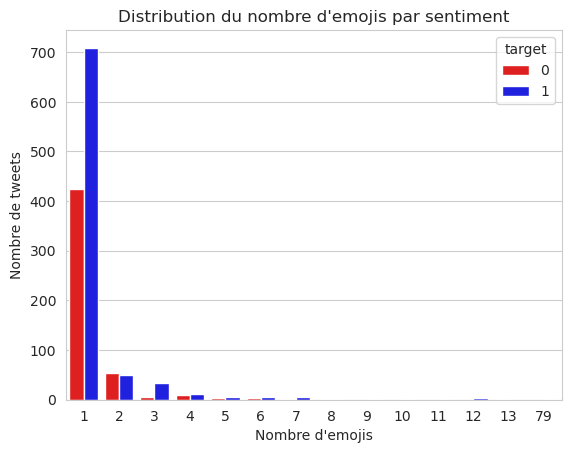

In [43]:
# Do add the emoji count to the dataframe
df = df.assign(**{"emoji_count": emoji_count})

# Display the distribution of the emoji count
df.loc[df["emoji_count"] > 0, ["emoji_count", "target"]].pipe(
    sns.countplot, x="emoji_count", hue="target", palette=["red", "blue"]
).set(
    title="Distribution du nombre d'emojis par sentiment",
    xlabel="Nombre d'emojis",
    ylabel="Nombre de tweets",
)
plt.show()

Il est difficile de tirer des conclusions sur la présence des emojis dans les tweets et leur impact sur le sentiment du fait de leur volume anedoctique et que le jeu de données n'est pas sensé en contenir.<br>
Pour ne pas introduire de biais dans l'entraînement du modèle, nous filtrons tous les tweets avec des emojis de notre jeu de données pour l'entraînement et l'évaluation.<br> 


L'idée à présent n'est pas de conserver tout le jeu de données mais d'écarter toutes les possibles outliers qui peuvent introduire du bruit dans l'entraînement du modèle.<br>
A présent, au vu des observations précédentes, je vais créer un version nettoyée du jeu de données avec plusieurs prétraitements.<br>
Ces fonctions seront **portables et pourront être utilisées dans le pipeline de traitement des données que ce soit sur sklearn ou tensorflow.**

In [44]:
# Définition de la fonction de preprocessing
def text_preprocessing(serie: pd.Series, remove_punct_and_digits=False) -> pd.Series:
    # Clean but keep the punctuation
    if not remove_punct_and_digits:
        serie = (
            serie.str.lower()  # lowercase the text
            .str.replace(r"https?://?\S+", " ", regex=True)  # remove urls
            .str.replace(r"www\.\w+\S+", " ", regex=True)  # remove urls
            .str.replace(r"@\w+", "@usertag", regex=True)  # remove mentions
            .str.replace(r"#\w+", " ", regex=True)  # remove hashtags
            .str.replace(r"(\w+)[.,!?;](\w+)", r"\1 \2", regex=True)
            .str.replace(r"\s{2,}", " ", regex=True)  # strip multiple spaces
            .str.strip()
        )
        return serie
    # Cleaned and remove all punctuation and numbers
    else:
        serie = (
            serie.str.lower()  # lowercase the text
            .str.replace(r"https?://?\S+", " ", regex=True)  # remove urls
            .str.replace(r"www\.\w+\S+", " ", regex=True)  # remove urls
            .str.replace(r"@\w+", "@usertag", regex=True)  # remove mentions
            .str.replace(r"#\w+", " ", regex=True)  # remove hashtags
            .str.replace(r"(\w+)[.,!?;](\w+)", r"\1 \2", regex=True)
            .str.replace(
                r"[\\/.,!?;_:()=<>\[\]\-]", " ", regex=True
            )  # replace special chars and punct '
            .str.replace(r"[0-9]", "", regex=True)  # remove numbers
            .str.replace(r"\s{2,}", " ", regex=True)  # strip multiple spaces
            .str.strip()
        )
        return serie

On a deux possibilités ici pour pouvoir utiliser le modèle de spacy.<br>
On peut soit log le modèle sur mflow et ensuite charger le modèle depuis mlflow.<br>
On peut également sauvegarder le modèle sur le disque et le charger depuis le disque.<br>
Pour conserver notre logique de travail, je vais log le modèle sur mflow et le charger depuis mlflow.

In [45]:
URI = "http://localhost:5000"
mlflow.set_tracking_uri(URI)

In [46]:
# Load the spacy model and disable the ner component
spacy_model = "en_core_web_sm"
disable = ["ner"]  # Only component to disable to get the best lemmatization

# Load the model without the ner component and download it if needed
try:
    nlp = spacy.load(spacy_model, disable=disable)
except OSError as e:
    print(e)
    print(f"Downloading the {spacy_model} model...")
    spacy.cli.download(spacy_model)
    # Add sleep time
    time.sleep(5)
    # Finally load the model
    print("Loading the model...")
    nlp = spacy.load(spacy_model, disable=disable)
finally:
    print(f"{spacy_model.upper()} model loaded successfully :)")
    print(f"Model components: {nlp.pipe_names}")

# Log the spacy model with mlflow
mlflow.spacy.log_model(
    nlp, f"spacy_{spacy_model}", registered_model_name=f"spacy_{spacy_model}"
)
mlflow.end_run()

2025/01/11 13:39:33 WARNING mlflow.spacy: Generating only the spacy flavor for the provided spacy model. This means the model can be loaded back via `mlflow.spacy.load_model`, but cannot be loaded back using pyfunc APIs like `mlflow.pyfunc.load_model` or via the `mlflow models` CLI commands. MLflow will only generate the pyfunc flavor for spacy models containing a pipeline component that is an instance of spacy.pipeline.TextCategorizer.


EN_CORE_WEB_SM model loaded successfully :)
Model components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


2025/01/11 13:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'spacy_en_core_web_sm' already exists. Creating a new version of this model...
2025/01/11 13:39:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: spacy_en_core_web_sm, version 7
Created version '7' of model 'spacy_en_core_web_sm'.
2025/01/11 13:39:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-trout-886 at: http://localhost:5000/#/experiments/0/runs/5b1cffdbcc32401fbdcc4f910883907c.
2025/01/11 13:39:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


In [47]:
# Save the spacy model URI
model_uri = (
    "../mlruns/0/5ce076a511c44429b2bcfbf7a02d0779/artifacts/spacy_en_core_web_sm"
)

In [48]:
class SpacyTokenizer:
    def __init__(self, model_uri: str):
        self.nlp = mlflow.spacy.load_model(model_uri)

    def tokenize(self, texts: List[str], lemmatize=False):
        # Error handling for input
        assert isinstance(texts, list), "Input must be a list of strings"
        assert isinstance(lemmatize, bool), "lemmatize must be a boolean"
        assert isinstance(texts[0], str), "List elements must be strings"
        # Tokenize the texts
        tokenized_texts = []
        # Tokenize and lemmatize
        if lemmatize:
            for doc in tqdm(self.nlp.pipe(texts, disable=["ner"])):
                tokenized_texts.append(" ".join([token.lemma_ for token in doc]))
        # Tokenize the text only
        else:
            for doc in tqdm(self.nlp.pipe(texts, disable=["ner", "lemmatizer"])):
                tokenized_texts.append(" ".join([token.text for token in doc]))
        # Return the tokenized texts
        return tokenized_texts

In [49]:
tokenizer = SpacyTokenizer(model_uri)
tokenizer.tokenize(["@user Hello world!!!"], lemmatize=False)

1it [00:00, 163.98it/s]


['@user Hello world ! ! !']

Plutôt que d'utiliser le tokenizer de spacy à chaque fois, je vais créer deux colonnes qui contiennent les textes déjà tokenisés et lemmatisés.<br>
Dans le modèle à déployer, il sera nécessaire d'utiliser cette classe avec l'uri du modèle spacy pour reproduire les mêmes résultats.

In [50]:
df = df.assign(
    **{
        "tokenized_text": lambda x: tokenizer.tokenize(
            x["text"].to_list(), lemmatize=False
        ),
        "tokenized_lemma_text": lambda x: tokenizer.tokenize(
            x["text"].to_list(), lemmatize=True
        ),
    }
)

1596630it [14:25, 1845.19it/s]
1596630it [15:09, 1756.00it/s]


Notre pipeleline est prêt à être créer.<br>
Plutôt que de l'utiliser à chaque fois sur les données de test, nous allons créer directementt les jeux de données pour l'entraînement déjà préparés.<br>
Pour le déploiement du modèle retenu, il sera toutefois nécessaire de relancer tout le pipeline avec le modèle de classification pour pouvoir le déployer par la suite avec toutes les étapes du début à la fin.<br>
Cela nous sera particulièrement utile pour les tests sur tensorflow où il sera contreproductif de réutiliser le pipeline sklearn sur les phrases d'entraînement.<br>
Pour s'assurer que les différents jeux seront comparables lors de la modélisation, on va effectuer les transformations pour filtrer des valeurs extrêmes non désirés.

In [51]:
# Preprocess the texts
df = df.assign(
    **{
        "tokenized_cleaned_text": text_preprocessing(
            df["tokenized_text"], remove_punct_and_digits=False
        ),
        "tokenized_cleaned_text_no_punct_and_digits": text_preprocessing(
            df["tokenized_text"], remove_punct_and_digits=True
        ),
        "tokenized_cleaned_lemma_text_no_punct_and_digits": text_preprocessing(
            df["tokenized_lemma_text"], remove_punct_and_digits=True
        ),
    }
)

La dernière étape avant de passer aux créations des jeux de tests et de filter les tweets avec trop ou pas assez de caractères pour écarter les outliers.<br>
Afin que la base d'entraînement et test soit équilibrée, on va filtrer les tweets avec plus d'une mention, qui n'ont pas d'emojis et dont le texte avec le plus de prétraitement (`cleaned_lemma`) ait au minimum 2 tokens.<br>
Cela nous évitera les situations où le modèle peut se retrouver sans token pour pouvoir prédire la classe de sentiment.

In [52]:
df = df.assign(
    **{
        "text_lemma_cleaned_tokens": df[
            "tokenized_cleaned_lemma_text_no_punct_and_digits"
        ]
        .str.split()
        .apply(len),
        "text_lemma_char_len": df[
            "tokenized_cleaned_text_no_punct_and_digits"
        ].str.len(),
    }
)

In [53]:
# Check the normal CI for the text length on the full processed text
df["text_lemma_char_len"].quantile([0.025, 0.975])

0.025     15.0
0.975    132.0
Name: text_lemma_char_len, dtype: float64

In [54]:
curated_df = (
    df.query("text_lemma_char_len >= 15 and text_lemma_char_len <= 132")
    .query("mention_count <= 1")
    .query("emoji_count == 0")
    .query("text_lemma_cleaned_tokens >=2")
)

In [55]:
curated_df.to_parquet("../data/processed/curated_df.parquet", index=False)
curated_df.shape

(1487207, 25)

# **Séparation des données d'entraînement et de test**

A présent, on va split les données et undersampler le jeu d'entraînement pour avoir une base de données plus rapide à entraîner mais **bien construite et équilibrée**.<br>
On gardera seulement 2% du jeu de données `curated` (environ 30000 lignes) à nouveau séparés en 80% pour l'entraînement et 20% pour le test.

In [3]:
curated_df = pd.read_parquet("../data/processed/curated_df.parquet")

In [4]:
features, _, target, _ = train_test_split(
    curated_df.drop(columns=["target"]),
    curated_df["target"],
    test_size=0.98,
    stratify=curated_df[["target", "mentionned"]],
    random_state=314,
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    stratify=features.assign(target=target)[["target", "mentionned"]],
    random_state=314,
)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23795, 24), (5949, 24), (23795,), (5949,))

Je sauvegarde les données d'entraînement et de test pour pouvoir les réutiliser dans les prochaines étapes.<br>

In [7]:
filtered_cols = [
    "hour",
    "text",
    "tokenized_text",
    "tokenized_lemma_text",
    "tokenized_cleaned_text",
    "tokenized_cleaned_text_no_punct_and_digits",
    "tokenized_cleaned_lemma_text_no_punct_and_digits",
]
X_train = X_train.filter(filtered_cols)
X_test = X_test.filter(filtered_cols)

# Save the preprocessed dataframe
X_train.to_pickle("../data/processed/X_train.pickle")
X_test.to_pickle("../data/processed/X_test.pickle")
y_train.to_pickle("../data/processed/y_train.pickle")
y_test.to_pickle("../data/processed/y_test.pickle")
# Save the columns names in a pickle file
with open("../data/processed/train_columns.pkl", "wb") as f:
    pickle.dump(filtered_cols, f)

Regardons la size du vocab en fonction des jeux de données :

In [8]:
for col in filtered_cols[2:]:
    vocab = set()
    for row in X_train[col].str.split().values:
        vocab.update(row)
    print(f"Vocab size for {col}: {len(vocab)}")

Vocab size for tokenized_text: 40875
Vocab size for tokenized_lemma_text: 36492
Vocab size for tokenized_cleaned_text: 23807
Vocab size for tokenized_cleaned_text_no_punct_and_digits: 22418
Vocab size for tokenized_cleaned_lemma_text_no_punct_and_digits: 19890


De même pour les tokens, cela nous aidera à déterminer le max sequence lenght pour le modèle de réseaux de neurones.<br>

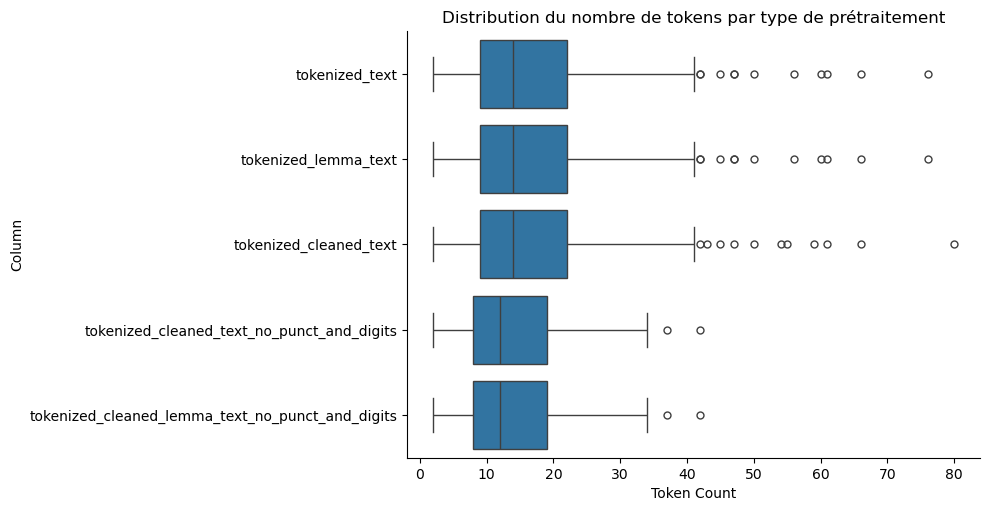

In [9]:
# Display the boxplot of the token count
token_count_df = X_train.iloc[:, 2:].apply(lambda x: x.str.split().apply(len))
sns.catplot(
    data=token_count_df.melt(var_name="Column", value_name="Token Count"),
    x="Token Count",
    y="Column",
    kind="box",
    height=5,
    aspect=2,
)
plt.title("Distribution du nombre de tokens par type de prétraitement")
plt.show()